# Balmer Jump Measurement

This notebook measures the Balmer Jumps in the CHAOS galaxies - one galaxy at a time

In [1]:
#import useful packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Set up plotting parameters

In [2]:
# set up Latex & universal fontsize for plotting
plt.rc('text',usetex=True)
fontsize=15
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

Pull galaxy information from files

In [3]:
# Read the files into arrays
regionName       = np.loadtxt("regions.list",  dtype=str)    # region name
observedFileName = np.loadtxt("origSpec.list", dtype=str)    # observed spectra
refitFileName    = np.loadtxt("refits.list",   dtype=str)    # refit continuum fits
nessFitFileName  = np.loadtxt("nessFits.list",   dtype=str)    # refit continuum fits

# Determine number of regions in our galaxy
nn = len(regionName)   

## Identify emission lines and set up spectrum specific continuum windows.

In [4]:
# Emission lines to avoid when fitting
lambdaEm = np.loadtxt('emissionLines.list', unpack=True, usecols=(0))

# Flags for Primary vs Secondary sample (primary = 1, secondary = 0)
#sampleFlags = np.loadtxt('rawJumpMeasurementDataAllWindows.txt', unpack=True, usecols=(11))

# Flags for fitting with observed vs continuum fit on red side (obs = 1, cont = 0) - all blue fit with obs
#fitFlags = np.loadtxt('rawJumpMeasurementDataAllWindows.txt', unpack=True, usecols=(12))

# Continuum windows used in fitting
blueBoxes = np.genfromtxt('blueBoxes.list', delimiter=',')
redBoxes  = np.genfromtxt('redBoxes.list',  delimiter=',')

# Arrays to hold selected boxes for specialized fits.
blueBoxesAll = np.full((nn, 6), 1, dtype=int)
redBoxesAll  = np.full((nn, 8), 1, dtype=int)
redBoxesNF  = np.full((nn, 8), 1, dtype=int)
redBoxesRF  = np.full((nn, 8), 1, dtype=int)
for i in range(len(redBoxesRF)):
    redBoxesRF[i] = (1,1,1,1,1,1,1,0)
#blueBoxesGood  = np.genfromtxt('blueBoxesGood.list',  delimiter=',')
#redBoxesGood  = np.genfromtxt('redBoxesGood.list',  delimiter=',')

In [5]:
class Spectrum():
    """
    Spectrum class implements the parameters for analyzing a spectrum's balmer jump.
    
    Parameters
    ----------
    region : string
        name of HII region   
    observedFile : string
        name of file that holds the observed spectrum data
    refitFile : string
        name of file that holds the modelled continuum data
    fit : int
        specifies either continuum or observed flux fitting (0=continuum, 1=observed)
    wave : list of floats
        the wavelength values corresponding to our flux list from observed spectrum
    flux : list of floats
        the flux values from observed spectrum
    err : list of floats
        the errors listed from the observed spectrum
    waveCont : list of floats
        the wavelength values corresponding to our flux list from the modelled continuum
    fluxCont : list of floats
        the flux values from the modelled continuum
    errCont : list of floats
        the errors listed from the modelled continuum       
    blueWaves : array of ints
        indicies of 'wave' that is blueward of the Balmer jump  
    redWaves : array of ints
        indicies of 'wave' that is redward of the Balmer jump    
    blueIndex : int
        index of wave where blue measurement is taken (3643 Angstroms)
    redIndex : int
        index of wave where red measurement is taken (3681 Angstroms)

    Methods
    -------
    findBoxes(boxes, boxesGood)
        Returns the continuum windows to be used for a given fit
    fitLine(boxesGood, fitColor, numMC)
        Returns the MC best fit parameters and line given the flags for good continuum windows, 
        the blue or red fit color, and the number of MC iterations to be used.
        return([measA, measM, measS], [slopeA, slopeM, slopeS], [interA, interM, interS], finalFitLine)
    plotSpectrum(blueY, redY, blueFit, redFit, blueBoxesGood, redBoxesGood)
        Plots a spectrum and its line fits given the blue and red y axis scaling, the fits, and the 
        boxes used in the fitting algorithm.
    plotComparisonSpectrum(blueY, redY, blueFitAll, blueFitGood, redFitAll, redFitGood, blueBoxesGood, redBoxesGood)
        Plots a spectrum and its line fits given the blue and red y axis scaling, the fits, and the 
        boxes used in the fitting algorithm. Compares All boxes with Good boxes line fits.
    plotHistograms(parameters, bins)
        Plots 8 histograms analyzing the MC parameters assigned to the fit lines in this order: 
        'Blue All Slope', 'Blue All Intercept', 'Red All Slope', 'Red All Intercept', 'Blue Good Slope', 
        'Blue Good Intercept', 'Red Good Slope', 'Red Good Intercept'. The parameters variable is 
        a list of lists which hold the parameters in the order listed above.
    writeData()
        Writes the fit measurements to a text file:
        RedAll, RAErr, RedGood, RGErr, BlueAll, BAErr, BlueGood, BGErr, JumpAll, JAErr, JumpGood, JGErr.
    """
    def __init__(self, region, observedFile, nessFitFile, refitFile):
        self.region        = region
        self.observedFile  = observedFile
        self.nessFitFile   = nessFitFile
        self.refitFile     = refitFile
        
        self.waveTot, self.fluxTot, self.errTot, self.fluxRF, self.contRF,  self.fluxNF, self.contNF = self.getSpectrumData()
        
        self.waveStart = np.where(self.waveTot > 3499)
        
        self.wave = self.waveTot[self.waveStart]
        self.flux = self.fluxTot[self.waveStart]
        self.err  = self.errTot[self.waveStart]
        
        self.blueWaves = np.where(self.wave <  3647)
        self.redWaves  = np.where(self.wave >  3646)
        self.blueIndex = np.abs(self.wave - 3643).argmin()
        self.redIndex  = np.abs(self.wave - 3681).argmin()


    def getSpectrumData(self):
        '''Returns the flux, wavelength, modelled stellar continuum for a spectrum'''
        wave, flux, err  = np.loadtxt(observedFile, unpack=True, usecols=(0,1,2))
        fluxRF, contRF   = np.loadtxt(refitFile, unpack=True, usecols=(1,3))
        fluxNF, contNF   = np.loadtxt(nessFitFile, unpack=True, usecols=(1,3))
        return wave, flux, err, fluxRF, contRF,  fluxNF, contNF

    def findBoxes(self, boxes, boxesGood):
        """
        Returns the selected boxes from a list of available boxes.
        """
        boxesUsed = []
        boxi = 0
        for box in boxes:
            if(boxesGood[i,boxi] > 0.1):
                boxesUsed.append(boxes[boxi])
            boxi += 1        
        return boxesUsed
                
    def fitLine(self, fit, boxesGood, continuumType, fitColor, numMC=1000):
        """
        Returns the measurement values, slope values and intersept values of a final MC fit line.
        (average, median, sigma)
        """
        measurements  = []           # measurements of either blue or red value
        w, f, c, e = [],[],[],[]     # lists for fitting window values

        if fitColor == 'red':
            boxes = redBoxes
        else:
            boxes = blueBoxes

        boxesUsed = self.findBoxes(boxes, boxesGood)
        
        wave, flux, err = self.wave, self.flux, self.err
        
        if continuumType == 'refit':
            cont = self.contRF
        else:
            cont = self.contNF

        # assign the windows from original wavelength, flux, error arrays to the lists 
        # containing only the windows we want
        boxi = 0
        for box in boxesUsed:
            istart = wave.tolist().index(box[0])
            iend = wave.tolist().index(box[1]) + 1
            for k in range(istart,iend):
                w.append(wave[k])
                f.append(flux[k])
                c.append(cont[k])
                e.append(err[k])                    
            boxi = boxi + 1   
            
        W, E = np.array(w), np.array(e)      # turn the lists to arrays
        if fit == 'continuum' and fitColor == 'red':
            F = np.array(c)
        else:
            F = np.array(f)
        
        MCslopes, MCintercepts = [],[]          # hold MC fit values for later analysis
        np.random.seed(628)
        for j in range(numMC):
            firstRun = []                       # holds the MC generated values for the first run. 

            for n in range(len(F)):
                # Generate the MC fit using random gaussian noise.
                MCF = F[n] + (E[n] * np.random.normal(loc=0.0, scale=1.0, size=None))
                firstRun.append(MCF)                           

            # Reapply MC fitting to smoothed spectrum.
            slope, intercept, r_value, p_value, std_err = stats.linregress(W, firstRun)
            MCslopes.append(slope)
            MCintercepts.append(intercept)
            fitLine = slope * self.wave + intercept

            if fitColor == 'blue':
                measurements.append(fitLine[self.blueIndex])
            else: 
                measurements.append(fitLine[self.redIndex])        

        measA,  measM,  measS  = np.average(measurements), np.median(measurements), np.std(measurements)
        slopeA, slopeM, slopeS = np.average(MCslopes),     np.median(MCslopes),     np.std(MCslopes)
        interA, interM, interS = np.average(MCintercepts), np.median(MCintercepts), np.std(MCintercepts) 
        finalFitLine = slopeA * self.wave + interA

        return (measurements, MCslopes, MCintercepts, finalFitLine)
        
    def plotComparisonSpectrum(self, blueY, redY, blueFit, redFitObs, redFitCSRF, redFitCSNF, 
                               blueBoxesGood, redBoxesGood):
        
        blueBoxesUsed = self.findBoxes(blueBoxes, blueBoxesGood)
        redBoxesUsed  = self.findBoxes(redBoxes,  redBoxesGood)
        bw, bf, bl, be, rw, rf, redObs, re, redCSRF, redCSNF = [],[],[],[],[],[],[],[],[],[]
        boxi = 0
        for box in blueBoxesUsed:
            istart = self.wave.tolist().index(box[0])
            iend = self.wave.tolist().index(box[1]) + 1
            for k in range(istart,iend):
                bw.append(self.wave[k])
                bf.append(self.flux[k])
                bl.append(blueFit[k])
                be.append(self.err[k])                    
            boxi = boxi + 1   
    
        boxi = 0
        for box in redBoxesUsed:
            istart = self.wave.tolist().index(box[0])
            iend = self.wave.tolist().index(box[1]) + 1
            for k in range(istart,iend):
                rw.append(self.wave[k])
                rf.append(self.flux[k])
                redObs.append(redFitObs[k])
                re.append(self.err[k])
                redCSRF.append(redFitCSRF[k])
                redCSNF.append(redFitCSNF[k])
            boxi = boxi + 1      
    
        BF, BL, RF, RedObs, RedCSRF, RedCSNF = np.array(bf), np.array(bl), np.array(rf), np.array(redObs), np.array(redCSRF), np.array(redCSNF)

        fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        fig.set_figheight(8)
        fig.set_figwidth(20)
        plt.setp(ax1.get_xticklabels(), visible=False)
        ax1.tick_params(axis='both', direction='in')
        ymax = blueY * 1.3
        ymin = redY  * 0.5
        ax1.axis([3499, 4350, ymin, ymax])        
        ax1.plot(self.wave, self.flux, color='black',  label = 'Observed Spectrum')
        ax1.plot(self.wave[0:550], self.contRF[0:550], color='orange', label = 'Modelled Continuum RF')
        ax1.plot(self.wave[0:900], self.contNF[0:900], color='yellow', label = 'Modelled Continuum NF')
        ax1.plot(self.wave[self.blueWaves], blueFit[self.blueWaves], color='blue', label = 'Blue Fit') 
        ax1.plot(self.wave[self.redWaves],  redFitObs[self.redWaves],   color='red',  label = 'Red Fit: Observed Spectrum') 
        ax1.plot(self.wave[self.redWaves],  redFitCSRF[self.redWaves],   color='green',  label = 'Red Fit: Stellar Continuum RF') 
        ax1.plot(self.wave[self.redWaves],  redFitCSNF[self.redWaves],   color='purple',  label = 'Red Fit: Stellar Continuum NF') 
        for l in lambdaEm:
            ax1.axvline(x=l, color='black', alpha = 0.5)
        plt.text(4350,(ymax+ymin)/4, self.region, fontsize=26,color='k',rotation=-90,va='center')
        boxi = 0
        for box in redBoxes:
            ax1.axvspan(box[0], box[1], alpha=0.05, color='red')
            if (redBoxesGood[i,boxi] > 0.1):
                ax1.axvspan(box[0], box[1], alpha=0.05, color='red')      
            boxi = boxi + 1 
        boxi = 0        
        for box in blueBoxes:
            ax1.axvspan(box[0], box[1], alpha=0.05, color='blue') 
            if (blueBoxesGood[i,boxi] > 0.1):
                ax1.axvspan(box[0], box[1], alpha=0.05, color='blue')  
            boxi = boxi + 1 
        ax1.legend(loc = 'best')
        #ax2 = plt.subplot(2,1,2, sharex = ax1) 
        #plt.tick_params(axis='both', direction='in')
        ax2.plot(bw, BF - BL, ls = ' ', marker = '.', color='blue', label='Observed Spectrum')
        ax2.plot(rw,  RF  - RedObs, ls = ' ', marker = '.', color='red', label='Observed Spectrum') 
        ax2.plot(rw,  RF  - RedCSRF,  ls = ' ', marker = '.', color='green',  label='Stellar Continuum RF')
        ax2.plot(rw,  RF  - RedCSNF,  ls = ' ', marker = '.', color='purple',  label='Stellar Continuum NF')
        #plt.plot(self.wave, 0.0, color = 'black', alpha = 0.5)
        ax2.axhline(y=0.0, color = 'k', alpha = 0.5)
        for l in lambdaEm:
            ax2.axvline(x=l, color='black', alpha = 0.5)
        #plt.text(4350,(ymax+ymin)/2, self.region, fontsize=26,color='k',rotation=-90,va='center')
        boxi = 0
        for box in redBoxes:
            ax2.axvspan(box[0], box[1], alpha=0.05, color='red')
            if (redBoxesGood[i,boxi] > 0.1):
                ax2.axvspan(box[0], box[1], alpha=0.05, color='red')      
            boxi = boxi + 1 
        boxi = 0        
        for box in blueBoxes:
            ax2.axvspan(box[0], box[1], alpha=0.05, color='blue') 
            if (blueBoxesGood[i,boxi] > 0.1):
                ax2.axvspan(box[0], box[1], alpha=0.05, color='blue')  
            boxi = boxi + 1 
        ax2.legend(loc = 'best')
        plt.subplots_adjust(top = 0.99, bottom = 0.01, hspace = 0.0, wspace = 0.16)
        figname = self.region + 'Spec.pdf'
        fig.savefig(figname)
        #fig.show()        
        

    
    def plotHistograms(self, parameters, bins=30):
        plt.figure(figsize=(20,4))
        titles = ['Blue All Slope', 'Blue All Intercept', 'Red All Slope Observed', 'Red All Intercept ContSub', 
                  'Blue All Slope', 'Blue All Intercept', 'Red Good Slope Observed', 'Red Good Intercept ContSub'] 
        mas, menos = np.empty(8), np.empty(8)
        for k in range(len(parameters)):           
            sig = np.std(parameters[k])
            med = np.median(parameters[k])
            lines = [med - sig, med, med + sig]
            plt.subplot(2, 4, k+1)
            plt.hist(parameters[k], bins)
            if(k < 4):
                vals = [parameters[k], parameters[k+4]]
                menos[k] = np.min(vals)
                mas[k]   = np.max(vals)
            else:
                menos[k] = menos[k-4]
                mas[k]   = mas[k-4]  
            plt.axis([menos[k], mas[k], 0, 100])
            for m in range(len(lines)):
                plt.axvline(lines[m], color = 'black', ls = '--')            
            plt.title(titles[k])
        plt.subplots_adjust(top = 0.99, bottom = 0.01, hspace = 0.4, wspace = 0.16)
        figname = self.region + 'Hist.pdf'
        plt.savefig(figname) 
        plt.show()
        
    def writeData(self, number, region, Blue, RedObs, RedCS):
        Blue       = np.average(Blue) 
        BlueErr    = np.std(Blue) 
        RedObs     = np.average(RedObs) 
        RedObsErr  = np.std(RedObs) 
        RedCS      = np.average(RedCS) 
        RedCSErr   = np.std(RedCS)   
        JumpObs    = Blue - RedObs
        JumpObsErr = np.sqrt(BlueErr**2 + RedObsErr**2) 
        JumpCS     = Blue - RedCS
        JumpCSErr  = np.sqrt(BlueErr**2 + RedCSErr**2)
        paramFull  = [Blue, BlueErr, RedObs, RedObsErr, RedCS, RedCSErr, JumpObs, JumpObsErr, JumpCS, JumpCSErr]
        paramRnd   = ["%.4f" % round(x,4) for x in paramFull] 
        
        if number == 0:
            with open("measurementData.txt", "w") as text_file:
                print('#  Region   Blue   BlueErr   RedObs   RedObsErr   RedCS   RedCSErr JumpObs   JumpObsErr   JumpCS  JumpCSErr', file=text_file)
        with open("measurementData.txt", "a") as text_file: 
            print(region, " ".join(str(x) for x in paramRnd), file=text_file)

<Figure size 1440x8640 with 0 Axes>

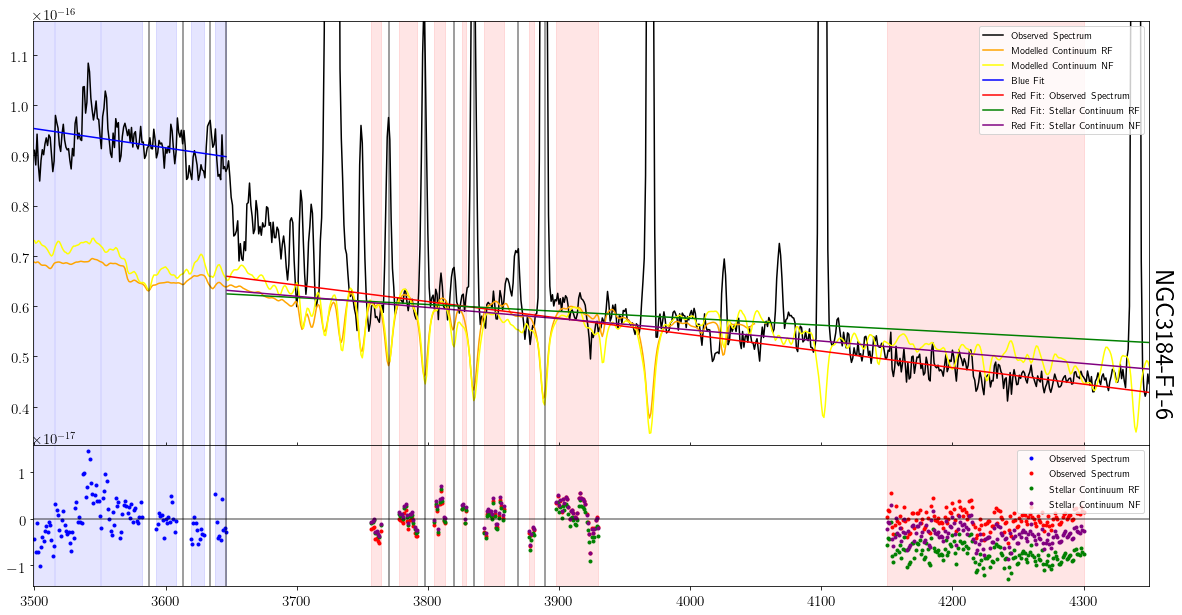

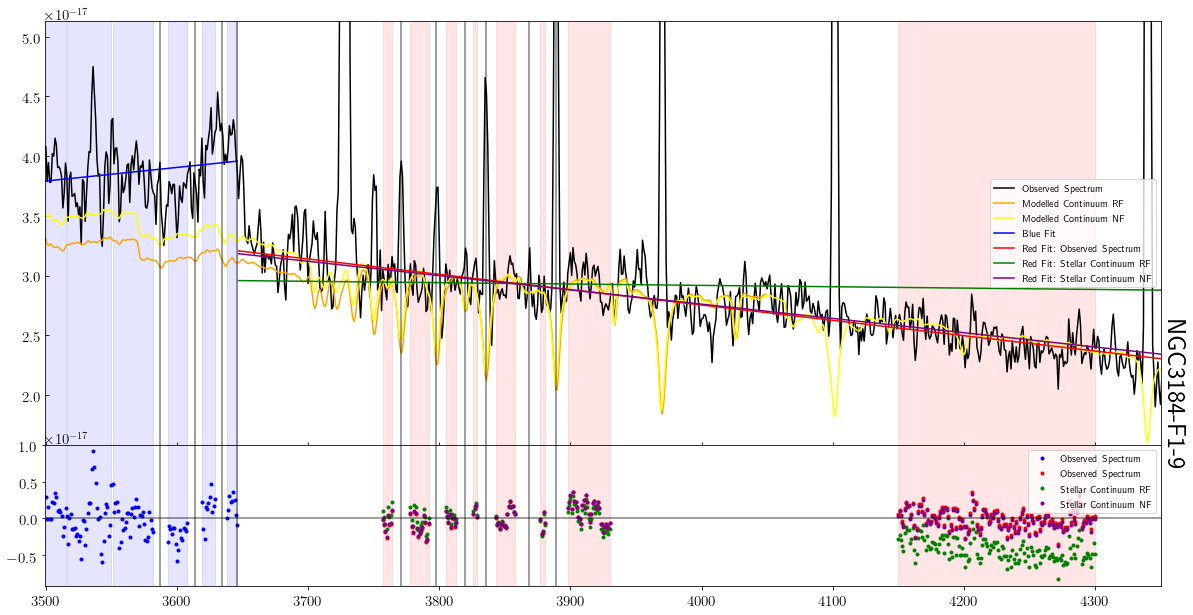

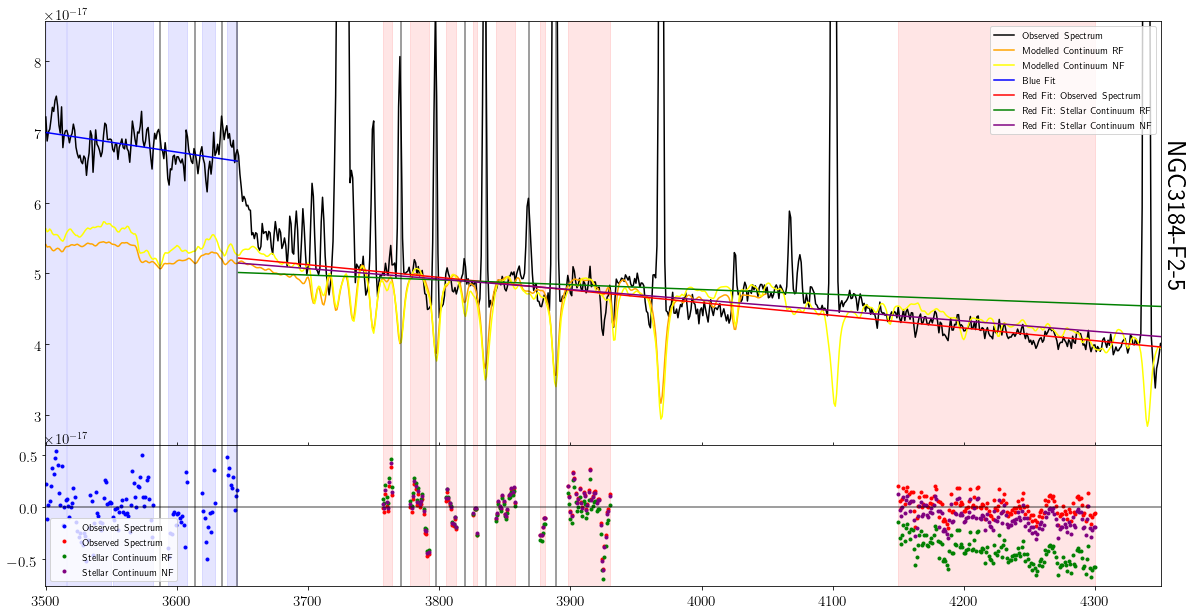

In [6]:
plt.figure(figsize=(20,120))
#change bin to 100, ymax to 300 and numMC to 10000 for analysis

for i in range(0,nn):
    region       = regionName[i]
    observedFile = observedFileName[i] 
    refitFile    = refitFileName[i]
    nessFitFile  = nessFitFileName[i]
    
    HII = Spectrum(region, observedFile, nessFitFile, refitFile) 

    fit = 'observed'
    fitColor = 'blue'    
    continuum = 'nessFit'   
    blueM,  blueS,  blueI,  blueFit    = HII.fitLine(fit, blueBoxesAll, continuum, fitColor)
    #refit goes to 4050 and nessFit to 4400
    fitColor = 'red'
    redMObs,  redSObs,  redIObs,  redFitObs    = HII.fitLine(fit, redBoxesAll, continuum, fitColor)
    continuum = 'refit'    

    fit = 'continuum'
    redMCSRF,  redSCSRF,  redICSRF,  redFitCSRF    = HII.fitLine(fit, redBoxesRF, continuum, fitColor)
    continuum = 'nessFit'   
    redMCSNF,  redSCSNF,  redICSNF,  redFitCSNF    = HII.fitLine(fit, redBoxesNF, continuum, fitColor)

    
    HII.plotComparisonSpectrum(blueM[0], redMObs[0], blueFit, redFitObs, redFitCSRF, redFitCSNF, blueBoxesAll, redBoxesAll)  
    #HII.plotResiduals(blueFit, redFitObs, redFitCS, blueBoxesAll, redBoxesAll)        
    #params = [blueS, blueI, redSObs, redIObs, blueS, blueI, redSCS, redICS]
    #HII.plotHistograms(params)
    #HII.writeData(i, region, blueM, redMObs, redMCS)